# Mercedes-Benz Greener Manufacturing Case Study

**Data Source: https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/data**

## Problem Statment: Can you cut the time a Mercedes-Benz spends on the test bench?

1. Since the first automobile, the Benz Patent Motor Car in 1886, Mercedes-Benz has stood for important automotive innovations. These include, for example, the passenger safety cell with crumple zone, the airbag and intelligent assistance systems. Mercedes-Benz applies for nearly 2000 patents per year, making the brand the European leader among premium car makers. Daimler’s Mercedes-Benz cars are leaders in the premium car industry. With a huge selection of features and options, customers can choose the customized Mercedes-Benz of their dreams. 

2. To ensure the safety and reliability of each and every unique car configuration before they hit the road, Daimler’s engineers have developed a robust testing system. But, optimizing the speed of their testing system for so many possible feature combinations is complex and time-consuming without a powerful algorithmic approach. As one of the world’s biggest manufacturers of premium cars, safety and efficiency are paramount on Daimler’s production lines.

3. In this competition, Daimler is challenging to reduce the time that cars spend on the test bench.

## Data Description:

1. This dataset contains an anonymized set of variables, each representing a custom feature in a Mercedes car. For example, a variable could be 4WD, added air suspension, or a head-up display.

2. The ground truth is labeled ‘y’ and represents the time (in seconds) that the car took to pass testing for each variable.

3. File descriptions: Variables with letters are categorical. Variables with 0/1 are binary values.

4. train.csv - the training set
5. test.csv - the test set, you must predict the 'y' variable for the 'ID's in this file
6. sample_submission.csv - a sample submission file in the correct format

## Data Analysis

In [1]:
# Importing all necessary modules.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
from sklearn.base import BaseEstimator,TransformerMixin,ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.utils import check_array
from sklearn.metrics import r2_score
# keras 
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint

# model evaluation
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectFromModel

# To make Results reproducible
seed = 40

import warnings
warnings.filterwarnings('ignore')
color = sns.color_palette()
%matplotlib inline

Using TensorFlow backend.


**The number of rows are small with 388 columns. So We should be take care about not to overfit.**

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (4209, 378)
Test shape :  (4209, 377)


In [3]:
train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


### Features of Data:
1. **ID** : ID column of data.
2. **y** : Target Variable. 
3. **X0-X385** : Data columns.

### Target Variable(y):

"y" is the variable we need to predict. So let us do perform analysis on this variable.

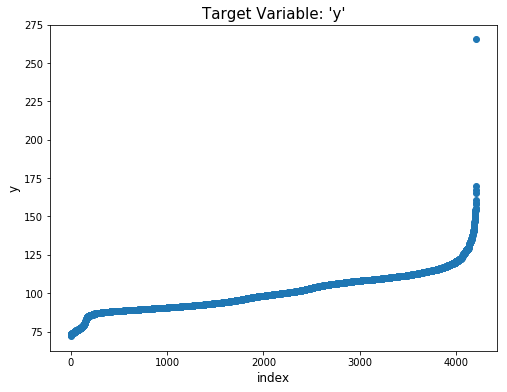

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.y.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Target Variable: 'y'",fontsize=15)
plt.show()

**Value of "y" is fairly spread across the range between 70-200**

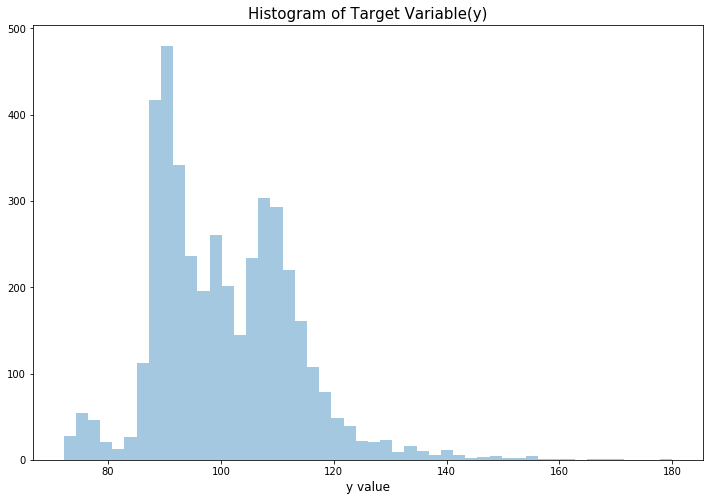

In [5]:
ulimit = 180
train_df['y'].ix[train_df['y']>ulimit] = ulimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.y.values, bins=50, kde=False)
plt.xlabel('y value', fontsize=12)
plt.title("Histogram of Target Variable(y)",fontsize=15)
plt.show()

In [6]:
print('min: {} max: {} mean: {} std: {}'.format(min(train_df['y'].values), max(train_df['y'].values), train_df['y'].values.mean(), train_df['y'].values.std()))
print('Count of values above 180: {}'.format(np.sum(train_df['y'].values > 180)))

min: 72.11 max: 180.0 mean: 100.64904727963888 std: 12.481281731120474
Count of values above 180: 0


#### Observations of Target Variable y:

1. **We can observe that most of the values lies between 90-120. So avg production time is 90-120.**
2. So we have a pretty **standard distribution** here, which is centred around almost exactly 100. 
3. The fact that ID is not equal to the row ID seems to suggest that the **train and test sets are randomly sampled**.

### Variables/Feature Analysis.

In [7]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,float64,1
2,object,8


**So majority of the columns are integers with 8 categorical features and 1 float feature (target variable)**

In [8]:
dtype_df.ix[:10,:]

,Count,Column Type
0,ID,int64
1,y,float64
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


**X0 to X8 are the categorical columns.**

#### Check for the missing values.

In [9]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


**We don't have any missing values.**

In [10]:
cols = [c for c in train_df.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
train_df[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

In [11]:
counts = [[], [], []]
for c in cols:
    typ = train_df[c].dtype
    uniq = len(np.unique(train_df[c]))
    if uniq == 1: counts[0].append(c)
    elif uniq == 2 and typ == np.int64: counts[1].append(c)
    else: counts[2].append(c)

print('Constant features: {} Binary features: {} Categorical features: {}\n'.format(*[len(c) for c in counts]))

print('Constant features:', counts[0])
print('Categorical features:', counts[2])

Constant features: 12 Binary features: 356 Categorical features: 8

Constant features: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
Categorical features: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


In [12]:
unique_values_dict = {}
for col in train_df.columns:
    if col not in ["ID", "y", "X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        unique_value = str(np.sort(train_df[col].unique()).tolist())
        tlist = unique_values_dict.get(unique_value, [])
        tlist.append(col)
        unique_values_dict[unique_value] = tlist[:]
for unique_val, columns in unique_values_dict.items():
    print("Columns containing the unique values : ",unique_val)
    print(columns)
    print("--------------------------------------------------")

Columns containing the unique values :  [0, 1]
['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145'

#### Categorical features.

In [13]:
# Let's print some categorical feature rows.
cat_feat = counts[2]
train_df[cat_feat].head()

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n


#### Features:
1. Constant features: 12 
2. Binary features: 356 
3. Categorical features: 8

**We have 12 features which only have a single value in them - these are pretty useless for supervised algorithms, and should probably be dropped.**

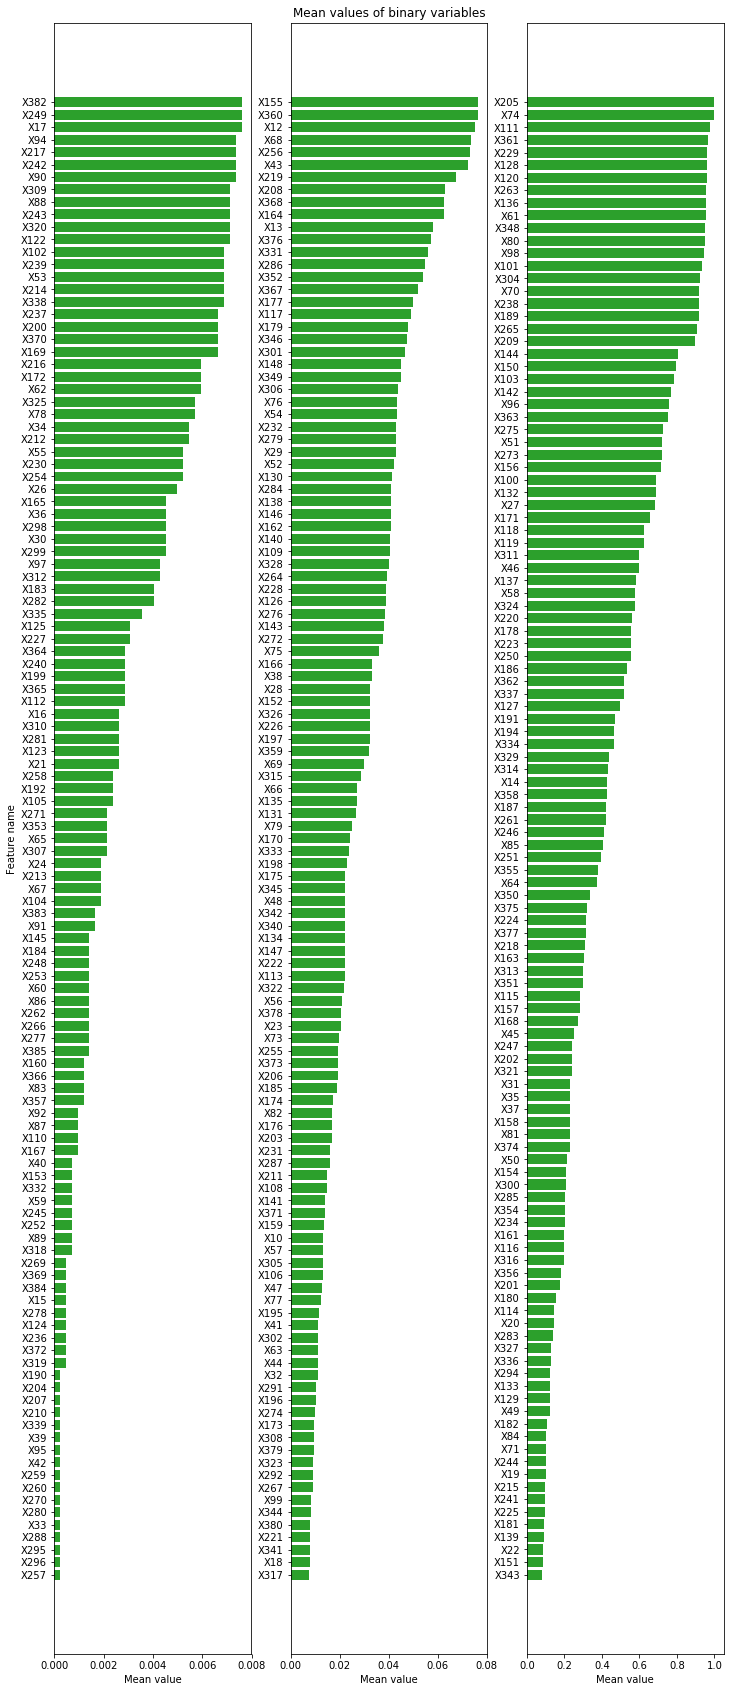

In [14]:
binary_means = [np.mean(train_df[c]) for c in counts[1]]
binary_names = np.array(counts[1])[np.argsort(binary_means)]
binary_means = np.sort(binary_means)

fig, ax = plt.subplots(1, 3, figsize=(12,30))
ax[0].set_ylabel('Feature name')
ax[1].set_title('Mean values of binary variables')
for i in range(3):
    names, means = binary_names[i*119:(i+1)*119], binary_means[i*119:(i+1)*119]
    ax[i].barh(range(len(means)), means, color=color[2])
    ax[i].set_xlabel('Mean value')
    ax[i].set_yticks(range(len(means)))
    ax[i].set_yticklabels(names, rotation='horizontal')
plt.show()

From above plot we can understand the general mean values of all Binary features.

# Machine Learning Algorithms.

**We can solve Regression problem to optimize the Production Time Feature (i.e. Target Variable = y).**

## Baseline Model 1: xgboost model 

To analyse Important Variables

In [15]:
# Data Preprocessing.

# LabelEncoder: Used to Encode labels with value between 0 and n_classes-1.

for f in ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values)) # Fit label encoder
        train_df[f] = lbl.transform(list(train_df[f].values)) # Transform labels to normalized encoding.
        
# Dropping ID feature & creating saperate Input/Output training data.
train_y = train_df['y'].values
train_X = train_df.drop(["ID", "y"], axis=1)

# Reference : https://xgboost.readthedocs.io/en/latest/python/python_intro.html
def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100, feval=xgb_r2_score, maximize=True)

[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[10:41:50] /workspace/sr

[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[10:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[10:41:50] /work

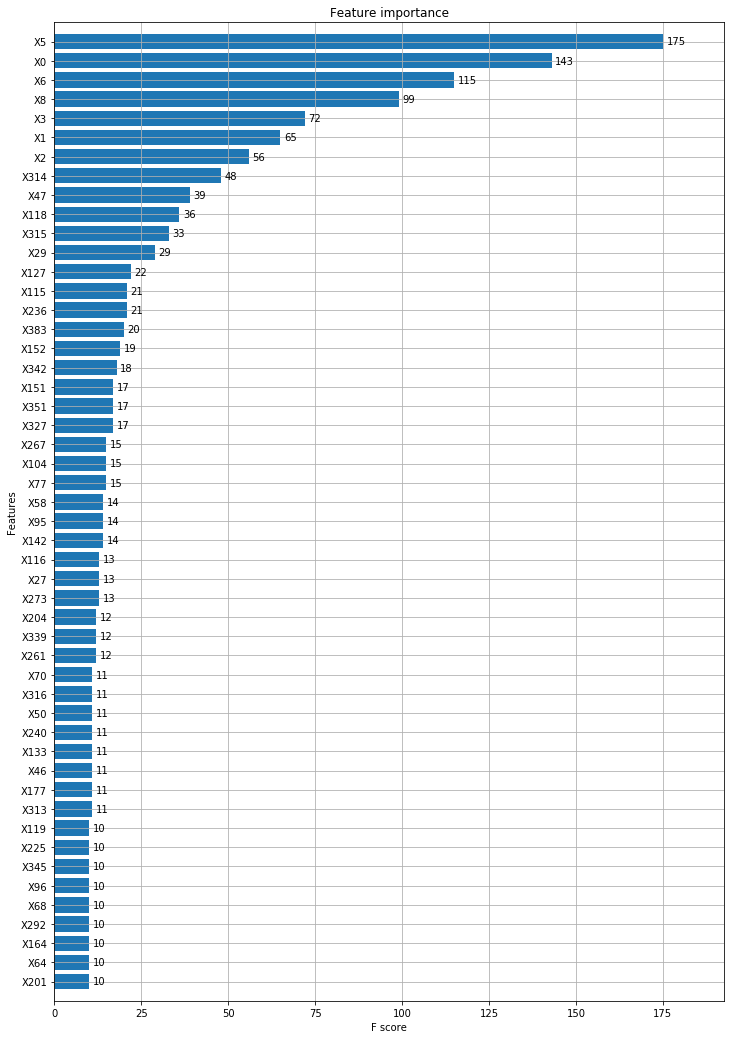

In [16]:
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Observations:

1. **Categorical features X5,X0,X8,X6,X1,X2,X3 are highly important in prediction of XGBoost model. **
2. **Binary features are less important comparitively.**
3. **We have dropped ID feature as it is not important.**

## Baseline Model 2: Random Forest model 

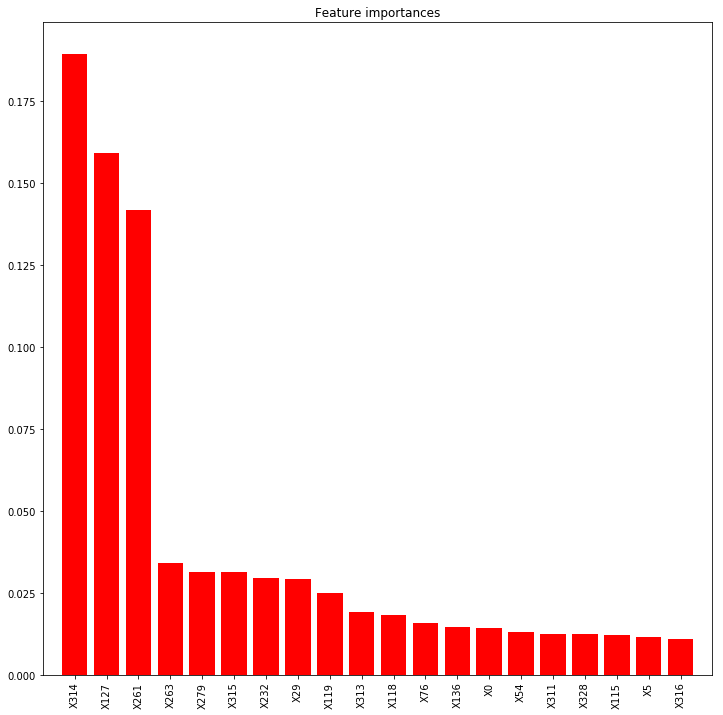

In [17]:
from sklearn import ensemble
model = ensemble.RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)
feat_names = train_X.columns.values

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

### Observations:

1. **Binary features X314,X127,X261 are highly important in the prediction of Random forest model. **
2. **Categorical features are less important comparitively.**
3. **We have dropped ID feature as it is not important.**

## XGboost Regression model. 

**Creating the components using various dimensionality reduction techniques.**

In [19]:
# Reference : https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

from sklearn.decomposition import PCA, FastICA, TruncatedSVD
# Dimensionality reduction techniques
n_comp = 15

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train_X)
tsvd_results_test = tsvd.transform(test)
# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_train = pca.fit_transform(train_X)
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(train_X)
ica2_results_test = ica.transform(test)

# Append decomposition components to datasets
for i in range(1, n_comp+1):
    train['tsvd_' + str(i)] = tsvd_results_train[:,i-1]
    test['tsvd_' + str(i)] = tsvd_results_test[:, i-1]
    
    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]
    
    train['ica_' + str(i)] = ica2_results_train[:,i-1]
    test['ica_' + str(i)] = ica2_results_test[:, i-1]
    
y_mean = np.mean(y_train)

In [20]:
# Reference : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

import xgboost as xgb

# Prepare dict of params for xgboost model.
xgb_params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth':6,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1}


# Creating DMatrices for Xgboost training
dtrain = xgb.DMatrix(train, y_train)
dtest = xgb.DMatrix(test)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params,dtrain,num_boost_round=700,verbose_eval=50,show_stdv=False)

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# Train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

[0]	train-rmse:12.3841	test-rmse:12.385
[50]	train-rmse:10.7518	test-rmse:10.8754
[100]	train-rmse:9.57748	test-rmse:9.84481
[150]	train-rmse:8.73635	test-rmse:9.16087
[200]	train-rmse:8.13691	test-rmse:8.72088
[250]	train-rmse:7.70472	test-rmse:8.44323
[300]	train-rmse:7.3866	test-rmse:8.27705
[350]	train-rmse:7.14044	test-rmse:8.18174
[400]	train-rmse:6.93932	test-rmse:8.12804
[450]	train-rmse:6.77325	test-rmse:8.09886
[500]	train-rmse:6.63014	test-rmse:8.084
[550]	train-rmse:6.51027	test-rmse:8.07597
[600]	train-rmse:6.40507	test-rmse:8.07439
[650]	train-rmse:6.30951	test-rmse:8.07828
[699]	train-rmse:6.22381	test-rmse:8.08397
700
[04:52:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[04:52:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[04:52:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, m

[04:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[04:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[04:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[04:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[04:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[04:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[04:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[04:52:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[04:52:05] /work

[04:52:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[04:52:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[04:52:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[04:52:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[04:52:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[04:52:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[04:52:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[04:52:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[04:52:06] /work

[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /work

[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[04:52:07] /work

[04:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[04:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[04:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[04:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[04:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[04:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[04:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[04:52:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[04:52:08] /work

[04:52:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[04:52:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[04:52:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[04:52:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[04:52:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[04:52:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[04:52:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[04:52:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[04:52:09] /work

[04:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[04:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[04:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[04:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[04:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[04:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[04:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[04:52:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[04:52:10] /work

[04:52:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[04:52:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[04:52:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[04:52:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[04:52:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[04:52:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[04:52:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[04:52:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[04:52:11] /work

### Observations:
1. **After 700 num_boost_round: 1. train-rmse:6.22381 2. test-rmse:8.08397**
2. We have pretty decent values of Train & Test error parameter(RMSE).
3. Model is performing nicely & not overfitting.

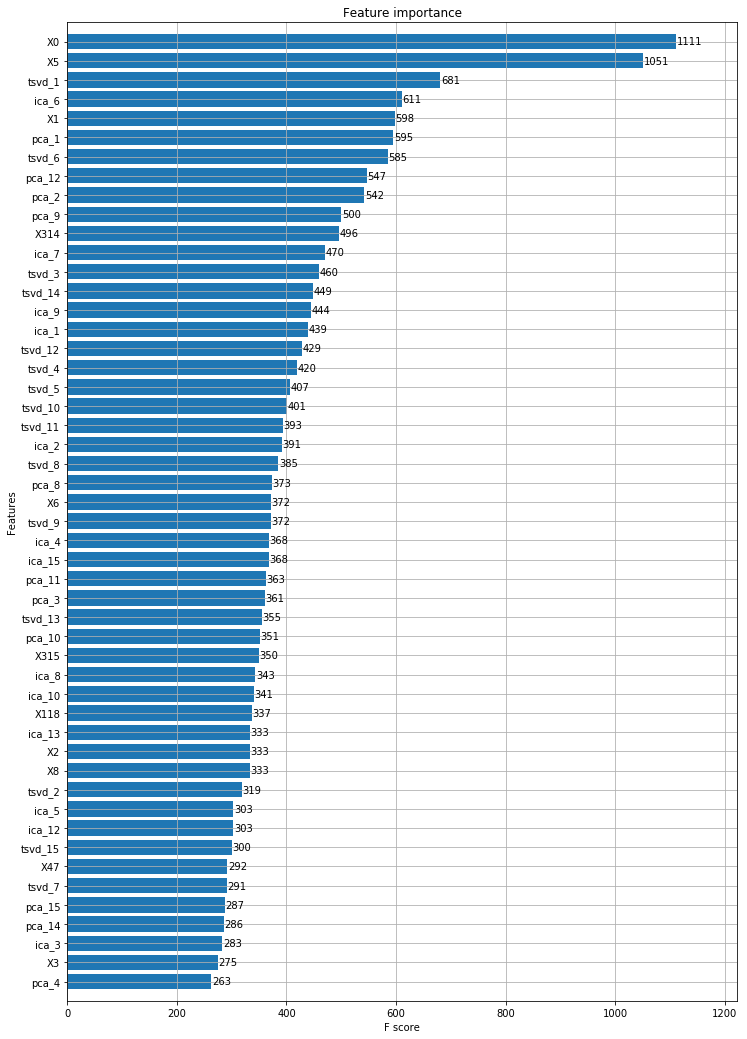

In [21]:
# Plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Observations:
1. Categorical features **X0 & X5 are highly important** in the prediction of our XGBoost model.
2. **TSVD,PCA & ICA generated features are also contributing effectively in the prediction.**
3. We can also **drop the features that are less important** to increase the model effectivity/time to predict target Variable.

In [22]:
# check f2-score (to get higher score - increase num_boost_round in previous cell)
from sklearn.metrics import r2_score

# now fixed, correct calculation
print(r2_score(dtrain.get_label(), model.predict(dtrain)))

0.718001643662283


**r2_score = 0.718**

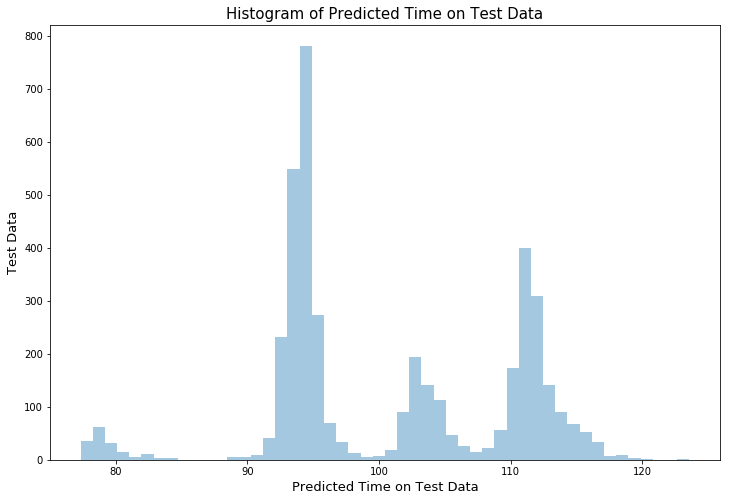

In [23]:
test = pd.read_csv('test.csv')
y_pred = model.predict(dtest)
output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('XGB_test_results.csv', index=False)
output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
plt.figure(figsize=(12,8))
sns.distplot(output.y.values, bins=50, kde=False)
plt.xlabel('Predicted Time on Test Data', fontsize=13)
plt.ylabel('Test Data', fontsize=13)
plt.title('Histogram of Predicted Time on Test Data', fontsize=15)
plt.show()

## Stacked Regression model. 

In [16]:
# Reference: https://github.com/nilaysen/Mercedes-Benz-Greener-Manufacturing-Kaggle/blob/master/merc.py

class StackingEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator

    
    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

In [17]:
# Import the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (4209, 378)
Test shape :  (4209, 377)


In [18]:
# Data Preprocessing.

# LabelEncoder: Used to Encode labels with value between 0 and n_classes-1.

for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))# Fit label encoder
        train[c] = lbl.transform(list(train[c].values))# Transform labels to normalized encoding.
        test[c] = lbl.transform(list(test[c].values))# Transform labels to normalized encoding.

# Dropping ID feature & creating saperate Input/Output training data.
train_y = train['y'].values
y_mean = np.mean(train_y)
id_test = test['ID'].values
train = train.drop(["ID"], axis=1)
test = test.drop(["ID"], axis=1)                  
# Reference : https://xgboost.readthedocs.io/en/latest/python/python_intro.html
def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

# Save columns list before adding the decomposition components

usable_columns = list(set(train.columns) - set(['y']))

**Creating the components using various dimensionality reduction techniques.**

In [19]:
# Dimensionality reduction techniques
n_comp = 15

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test)
# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=42)
grp_results_train = grp.fit_transform(train.drop(["y"], axis=1))
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=42)
srp_results_train = srp.fit_transform(train.drop(["y"], axis=1))
srp_results_test = srp.transform(test)

# Append decomposition components to datasets
for i in range(1, n_comp+1):
    
    train['tsvd_' + str(i)] = tsvd_results_train[:,i-1]
    test['tsvd_' + str(i)] = tsvd_results_test[:, i-1]
    
    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]
    
    train['ica_' + str(i)] = ica2_results_train[:,i-1]
    test['ica_' + str(i)] = ica2_results_test[:, i-1]
    
    train['grp_' + str(i)] = grp_results_train[:, i-1]
    test['grp_' + str(i)] = grp_results_test[:, i-1]

    train['srp_' + str(i)] = srp_results_train[:, i-1]
    test['srp_' + str(i)] = srp_results_test[:,i-1]

In [20]:
# final_train and final_test are data to be used only the stacked model (does not contain PCA, SVD... arrays) 

final_train = train[usable_columns].values
final_test = test[usable_columns].values

# Reference : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

import xgboost as xgb

# Prepare dict of params for xgboost model.
xgb_params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth':5,
    'subsample': 0.9,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1}


# Creating DMatrices for Xgboost training
dtrain = xgb.DMatrix(train.drop(["y"], axis=1), train_y)
dtest = xgb.DMatrix(test)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params,dtrain,num_boost_round=1000,verbose_eval=50,show_stdv=False)

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# Train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
y_pred = model.predict(dtest)

[0]	train-rmse:12.6392	test-rmse:12.638
[50]	train-rmse:11.0477	test-rmse:11.1558
[100]	train-rmse:9.90336	test-rmse:10.161
[150]	train-rmse:9.10037	test-rmse:9.5143
[200]	train-rmse:8.53487	test-rmse:9.10244
[250]	train-rmse:8.13785	test-rmse:8.84734
[300]	train-rmse:7.84902	test-rmse:8.69675
[350]	train-rmse:7.63858	test-rmse:8.60636
[400]	train-rmse:7.46158	test-rmse:8.55571
[450]	train-rmse:7.31058	test-rmse:8.53298
[500]	train-rmse:7.1737	test-rmse:8.52107
[550]	train-rmse:7.05194	test-rmse:8.51768
[600]	train-rmse:6.94264	test-rmse:8.52118
[650]	train-rmse:6.84518	test-rmse:8.52708
[700]	train-rmse:6.74954	test-rmse:8.5383
[750]	train-rmse:6.6645	test-rmse:8.54567
[800]	train-rmse:6.57573	test-rmse:8.55308
[850]	train-rmse:6.49414	test-rmse:8.5616
[900]	train-rmse:6.41803	test-rmse:8.56904
[950]	train-rmse:6.34769	test-rmse:8.57765
[999]	train-rmse:6.28061	test-rmse:8.58585
1000
[11:09:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 prune

[11:09:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[11:09:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:09:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:09:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[11:09:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:09:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:09:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:09:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:09:49] /work

[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /work

[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:09:50] /work

[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /work

[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:09:51] /work

[11:09:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[11:09:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:09:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[11:09:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:09:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:09:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:09:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:09:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:09:52] /work

[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /work

[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[11:09:53] /work

[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /work

[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[11:09:54] /work

[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[11:09:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[11:09:55] /work

[11:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[11:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[11:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[11:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[11:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[11:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:09:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[11:09:56] /work

In [21]:
# Train the stacked models then predict the test data !!
from sklearn.pipeline import make_pipeline, make_union
Stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001,loss="huber",max_features=0.55, 
                                                          min_samples_leaf=18, 
                                                          min_samples_split=14, subsample=0.7)),
    LassoLarsCV())



Stacked_pipeline.fit(final_train, train_y)
predictions = Stacked_pipeline.predict(final_test)

# R2 Score on the entire Train data when averaging

print('R2 score on train data:')
print(r2_score(train_y,Stacked_pipeline.predict(final_train)*0.2855 + model.predict(dtrain)*0.7145))

# Average the preditionon test data  of both models then save it on a csv file.

sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = y_pred*0.75 + predictions*0.25
sub.to_csv('stacked_model_pred.csv', index=False)

R2 score on train data:
0.6805083932610694


### Observations:
1. **After 1000 num_boost_round: 1. train-rmse:6.28061 2. test-rmse:8.58585**
2. We have pretty decent values of Train & Test error parameter(RMSE).
3. Model is performing nicely & not overfitting.
4. **R2 score on train data: 0.6805083932610694**

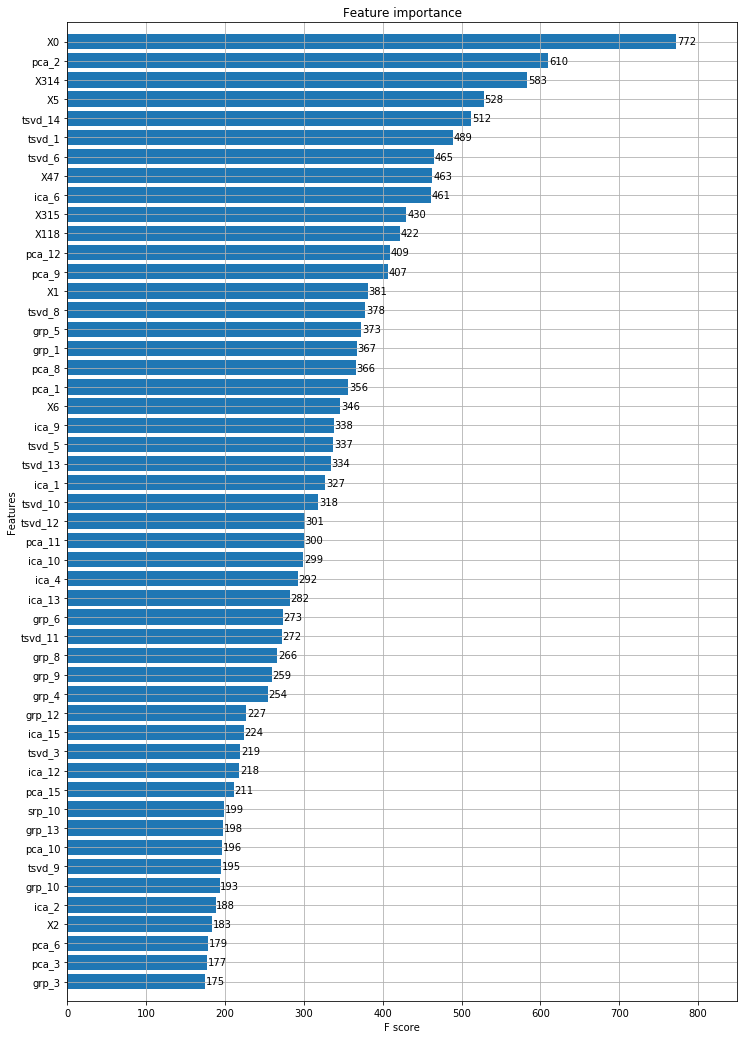

In [22]:
# Plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Observations:
1. Categorical features **X0 & X5 are highly important** in the prediction of our XGBoost model.
2. **TSVD,PCA & ICA generated features are also contributing effectively in the prediction.**
3. We can also **drop the features that are less important** to increase the model effectivity/time to predict target Variable.

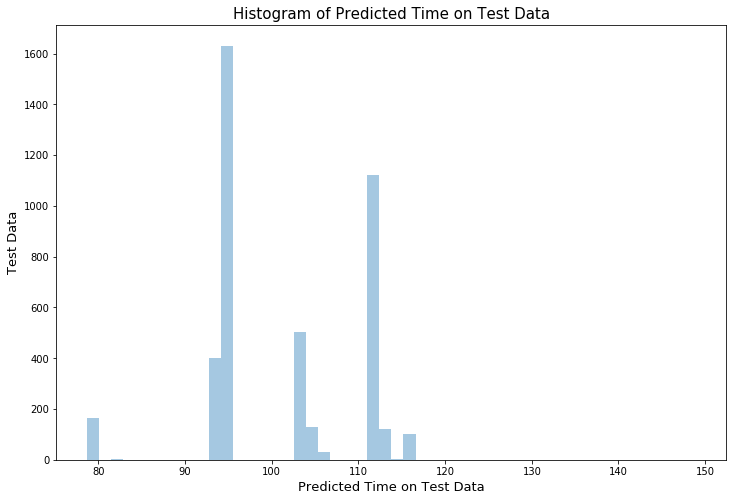

In [23]:
test = pd.read_csv('test.csv')

output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': predictions})

plt.figure(figsize=(12,8))
sns.distplot(output.y.values, bins=50, kde=False)
plt.xlabel('Predicted Time on Test Data', fontsize=13)
plt.ylabel('Test Data', fontsize=13)
plt.title('Histogram of Predicted Time on Test Data', fontsize=15)
plt.show()

# Deep Learning Algorithms.

**We can solve Regression problem to optimize the Production Time Feature (i.e. Target Variable = y).**

## Baseline Model: MLP using Keras

In [19]:
# Data preprocessing.

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# removing the outliers.
train = train.loc[train['y'] < 200, :]

# seperating label and features.
y_train = train['y']

train = train.drop(["ID", "y"], axis=1)

test = test.drop(["ID"], axis=1)

# label encoding the categorical features for dimension reduction.
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

In [20]:
print(train.shape)
print(test.shape)

(4208, 376)
(4209, 376)


In [21]:
from keras import optimizers

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Define custom R2 metrics for Keras backend.
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

# Reference:https://stackoverflow.com/questions/45250100/kerasregressor-coefficient-of-determination-r2-score

In [22]:
# Initialize input dimensions variable.
input_dims = train.shape[1]

In [23]:
# Architecture of MLP.

def nn_model():
    model = Sequential()
    # Input layer.
    model.add(Dense(input_dims, input_dim=input_dims))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    # hidden layer1
    model.add(Dense(input_dims))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    # hidden layer2
    model.add(Dense(input_dims//2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    # hidden layer3
    model.add(Dense(input_dims//4, activation='relu'))
    
    # Output layer (y_pred)
    model.add(Dense(1, activation='linear'))
       
    return model


model = nn_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 376)               141752    
_________________________________________________________________
batch_normalization_1 (Batch (None, 376)               1504      
_________________________________________________________________
activation_1 (Activation)    (None, 376)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 376)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 376)               141752    
_________________________________________________________________
batch_normalization_2 (Batch (None, 376)               1504      
_________________________________________________________________
activation_2 (Activation)    (None, 376)               0         
__________

In [26]:
filepath="weights_baseline_mlp.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_r2_keras', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [27]:
# Fitting the model on the training data.
model.compile(loss='mean_squared_error', optimizer=adam, metrics=[r2_keras])
history = model.fit(train, y_train, nb_epoch = 200, batch_size=50, shuffle=True,verbose=1,
                    validation_split=0.3,callbacks=callbacks_list)

Train on 2945 samples, validate on 1263 samples
Epoch 1/200
2945/2945 [==============================] - 1s 485us/step - loss: 92.0901 - r2_keras: 0.3881 - val_loss: 169.4072 - val_r2_keras: -0.2759

Epoch 00001: val_r2_keras improved from -inf to -0.27591, saving model to weights_baseline_mlp.best.hdf5
Epoch 2/200
2945/2945 [==============================] - 1s 178us/step - loss: 82.6006 - r2_keras: 0.4670 - val_loss: 78.7804 - val_r2_keras: 0.4198

Epoch 00002: val_r2_keras improved from -0.27591 to 0.41983, saving model to weights_baseline_mlp.best.hdf5
Epoch 3/200
2945/2945 [==============================] - 1s 178us/step - loss: 76.0682 - r2_keras: 0.5060 - val_loss: 78.7540 - val_r2_keras: 0.4185

Epoch 00003: val_r2_keras did not improve from 0.41983
Epoch 4/200
2945/2945 [==============================] - 1s 180us/step - loss: 68.1806 - r2_keras: 0.5521 - val_loss: 65.3115 - val_r2_keras: 0.5284

Epoch 00004: val_r2_keras improved from 0.41983 to 0.52835, saving model to weight


Epoch 00039: val_r2_keras did not improve from 0.55457
Epoch 40/200
2945/2945 [==============================] - 0s 163us/step - loss: 48.0995 - r2_keras: 0.6827 - val_loss: 84.6827 - val_r2_keras: 0.3736

Epoch 00040: val_r2_keras did not improve from 0.55457
Epoch 41/200
2945/2945 [==============================] - 0s 168us/step - loss: 44.8447 - r2_keras: 0.7131 - val_loss: 73.3099 - val_r2_keras: 0.4627

Epoch 00041: val_r2_keras did not improve from 0.55457
Epoch 42/200
2945/2945 [==============================] - 0s 166us/step - loss: 50.3760 - r2_keras: 0.6617 - val_loss: 67.8878 - val_r2_keras: 0.5035

Epoch 00042: val_r2_keras did not improve from 0.55457
Epoch 43/200
2945/2945 [==============================] - 0s 169us/step - loss: 46.5970 - r2_keras: 0.6952 - val_loss: 69.0374 - val_r2_keras: 0.4957

Epoch 00043: val_r2_keras did not improve from 0.55457
Epoch 44/200
2945/2945 [==============================] - 0s 165us/step - loss: 45.9290 - r2_keras: 0.7025 - val_loss: 7


Epoch 00079: val_r2_keras did not improve from 0.55457
Epoch 80/200
2945/2945 [==============================] - 0s 169us/step - loss: 40.6567 - r2_keras: 0.7344 - val_loss: 85.7003 - val_r2_keras: 0.3645

Epoch 00080: val_r2_keras did not improve from 0.55457
Epoch 81/200
2945/2945 [==============================] - 0s 165us/step - loss: 42.7611 - r2_keras: 0.7204 - val_loss: 86.3356 - val_r2_keras: 0.3612

Epoch 00081: val_r2_keras did not improve from 0.55457
Epoch 82/200
2945/2945 [==============================] - 0s 167us/step - loss: 40.3586 - r2_keras: 0.7430 - val_loss: 77.5648 - val_r2_keras: 0.4290

Epoch 00082: val_r2_keras did not improve from 0.55457
Epoch 83/200
2945/2945 [==============================] - 0s 166us/step - loss: 38.3312 - r2_keras: 0.7524 - val_loss: 124.5833 - val_r2_keras: 0.0644

Epoch 00083: val_r2_keras did not improve from 0.55457
Epoch 84/200
2945/2945 [==============================] - 0s 168us/step - loss: 41.4457 - r2_keras: 0.7320 - val_loss: 


Epoch 00158: val_r2_keras did not improve from 0.55457
Epoch 159/200
2945/2945 [==============================] - 1s 170us/step - loss: 31.7561 - r2_keras: 0.7948 - val_loss: 73.6027 - val_r2_keras: 0.4621

Epoch 00159: val_r2_keras did not improve from 0.55457
Epoch 160/200
2945/2945 [==============================] - 0s 169us/step - loss: 31.3577 - r2_keras: 0.7967 - val_loss: 77.9428 - val_r2_keras: 0.4274

Epoch 00160: val_r2_keras did not improve from 0.55457
Epoch 161/200
2945/2945 [==============================] - 1s 171us/step - loss: 30.5767 - r2_keras: 0.8029 - val_loss: 80.5044 - val_r2_keras: 0.4089

Epoch 00161: val_r2_keras did not improve from 0.55457
Epoch 162/200
2945/2945 [==============================] - 1s 171us/step - loss: 32.9883 - r2_keras: 0.7829 - val_loss: 82.7772 - val_r2_keras: 0.3892

Epoch 00162: val_r2_keras did not improve from 0.55457
Epoch 163/200
2945/2945 [==============================] - 1s 172us/step - loss: 34.5252 - r2_keras: 0.7719 - val_lo

**After 29 epochs:**
1. **Training Data: **

    1. **mean_squared_error loss: 48.2294** 
    2. **r2 metric: 0.6881**
2. **Validation Data: **
    1. **mean_squared_error loss: 61.74**  
    2. **r2 metric: 0.5546**

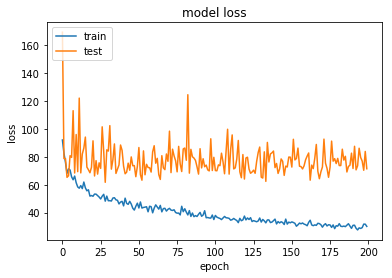

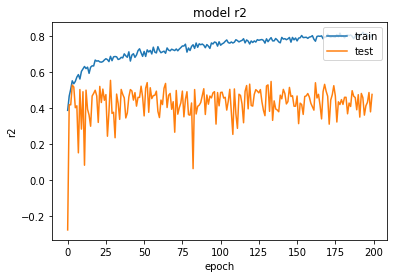

In [28]:
# Plot Loss & R2 metric.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r2')
plt.ylabel('r2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Observations:
1. We can easily see that model is predicting the Target variable brillianlty.
2. The Loss & R2 metric graphs converge after few epochs.
3. **No Overfitting.**

In [29]:
# Passing the Test data through the trained model & storing the results on disk.

Dtest = pd.read_csv('test.csv')
# predict results
res = model.predict(test).ravel()
print(res)

# create df and convert it to csv
output = pd.DataFrame({'id': Dtest["ID"], 'y': res})
output.to_csv('keras-baseline.csv', index=False)

[ 85.117355  94.5353    79.48812  ...  96.592606 107.8587    95.03621 ]


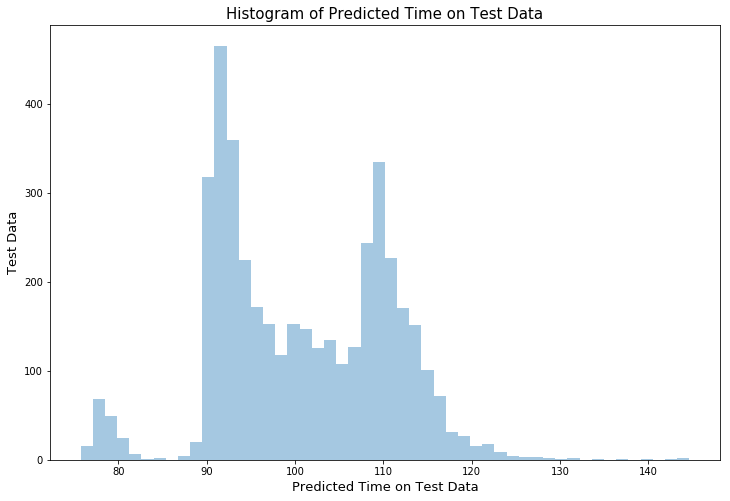

In [30]:
plt.figure(figsize=(12,8))
sns.distplot(output.y.values, bins=50, kde=False)
plt.xlabel('Predicted Time on Test Data', fontsize=13)
plt.ylabel('Test Data', fontsize=13)
plt.title('Histogram of Predicted Time on Test Data', fontsize=15)
plt.show()

### Observations:

1. The distribution of the Predicted Time (y) on Test Data is almost similar to the input data distribution.

## Final Model: MLP using Keras.

In [26]:
# Data preprocessing.

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# removing the outliers.
train = train.loc[train['y'] < 200, :]

# seperating label and features
y_train = train['y']
train = train.drop(["ID", "y"], axis=1)
test = test.drop(["ID"], axis=1)
y_mean = np.mean(y_train)
# label encoding the categorical features for dimension reduction
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

In [27]:
# Dimensionality reduction techniques

n_comp = 15

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=42)
tsvd_results_train = tsvd.fit_transform(train)
tsvd_results_test = tsvd.transform(test)
# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_train = pca.fit_transform(train)
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(train)
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=42)
grp_results_train = grp.fit_transform(train)
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=42)
srp_results_train = srp.fit_transform(train)
srp_results_test = srp.transform(test)

# Append decomposition components to datasets
for i in range(1, n_comp+1):
    train['tsvd_' + str(i)] = tsvd_results_train[:,i-1]
    test['tsvd_' + str(i)] = tsvd_results_test[:, i-1]
    
    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]
    
    train['ica_' + str(i)] = ica2_results_train[:,i-1]
    test['ica_' + str(i)] = ica2_results_test[:, i-1]
    
    train['grp_' + str(i)] = grp_results_train[:,i-1]
    test['grp_' + str(i)] = grp_results_test[:, i-1]
    
    train['srp_' + str(i)] = srp_results_train[:,i-1]
    test['srp_' + str(i)] = srp_results_test[:, i-1]

In [28]:
# Define custom R2 metrics for Keras backend
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Reference:https://stackoverflow.com/questions/45250100/kerasregressor-coefficient-of-determination-r2-score

In [29]:
# Model architecture definition.
def model():
    model = Sequential()
    #input layer
    model.add(Dense(input_dims, input_dim=input_dims))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    # hidden layer1
    model.add(Dense(input_dims))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    # hidden layer2
    model.add(Dense(input_dims//2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    # hidden layer3
    model.add(Dense(input_dims//4, activation='relu'))
    
    # output layer (y_pred)
    model.add(Dense(1, activation='linear'))
    
    # compile this model
    model.compile(loss='mean_squared_error',optimizer='adam',metrics=[r2_keras])
    
    # Visualize NN architecture
    print(model.summary())
    return model

In [30]:
# Initialize input dimension
input_dims = train.shape[1]

# To make Results reproducible
np.random.seed(seed)

# Initialize estimator, wrap model in KerasRegressor.
# Reference : https://stackoverflow.com/questions/44132652/keras-how-to-perform-a-prediction-using-kerasregressor

estimator = KerasRegressor(build_fn=model,nb_epoch=150,batch_size=20,verbose=1)

In [31]:
filepath="weights_final_mlp.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_r2_keras', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [32]:
# Fit the estimator.
history = estimator.fit(train,y_train,epochs=200,validation_split=0.3,verbose=2,shuffle=True,callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 451)               203852    
_________________________________________________________________
batch_normalization_1 (Batch (None, 451)               1804      
_________________________________________________________________
activation_1 (Activation)    (None, 451)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 451)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 451)               203852    
_________________________________________________________________
batch_normalization_2 (Batch (None, 451)               1804      
_________________________________________________________________
activation_2 (Activation)    (None, 451)               0         
__________

 - 1s - loss: 137.4791 - r2_keras: 0.0438 - val_loss: 65.9048 - val_r2_keras: 0.5042

Epoch 00035: val_r2_keras did not improve from 0.55786
Epoch 36/200
 - 1s - loss: 136.3221 - r2_keras: 0.0623 - val_loss: 74.0242 - val_r2_keras: 0.4204

Epoch 00036: val_r2_keras did not improve from 0.55786
Epoch 37/200
 - 1s - loss: 131.5206 - r2_keras: 0.0895 - val_loss: 84.6548 - val_r2_keras: 0.3336

Epoch 00037: val_r2_keras did not improve from 0.55786
Epoch 38/200
 - 1s - loss: 135.2275 - r2_keras: 0.0346 - val_loss: 70.0145 - val_r2_keras: 0.4651

Epoch 00038: val_r2_keras did not improve from 0.55786
Epoch 39/200
 - 1s - loss: 132.7252 - r2_keras: 0.0778 - val_loss: 111.2545 - val_r2_keras: 0.0951

Epoch 00039: val_r2_keras did not improve from 0.55786
Epoch 40/200
 - 1s - loss: 130.1230 - r2_keras: 0.1050 - val_loss: 70.2972 - val_r2_keras: 0.4605

Epoch 00040: val_r2_keras did not improve from 0.55786
Epoch 41/200
 - 1s - loss: 130.8125 - r2_keras: 0.0993 - val_loss: 101.9148 - val_r2_ker

 - 1s - loss: 92.7324 - r2_keras: 0.3655 - val_loss: 57.1178 - val_r2_keras: 0.5780

Epoch 00088: val_r2_keras improved from 0.57648 to 0.57795, saving model to weights_final_mlp.best.hdf5
Epoch 89/200
 - 1s - loss: 93.2697 - r2_keras: 0.3385 - val_loss: 69.7889 - val_r2_keras: 0.4642

Epoch 00089: val_r2_keras did not improve from 0.57795
Epoch 90/200
 - 1s - loss: 91.3862 - r2_keras: 0.3728 - val_loss: 61.3575 - val_r2_keras: 0.5383

Epoch 00090: val_r2_keras did not improve from 0.57795
Epoch 91/200
 - 1s - loss: 90.3736 - r2_keras: 0.3827 - val_loss: 64.8853 - val_r2_keras: 0.5161

Epoch 00091: val_r2_keras did not improve from 0.57795
Epoch 92/200
 - 1s - loss: 89.8115 - r2_keras: 0.3910 - val_loss: 76.3747 - val_r2_keras: 0.3934

Epoch 00092: val_r2_keras did not improve from 0.57795
Epoch 93/200
 - 1s - loss: 89.1365 - r2_keras: 0.3966 - val_loss: 58.3653 - val_r2_keras: 0.5553

Epoch 00093: val_r2_keras did not improve from 0.57795
Epoch 94/200
 - 1s - loss: 85.9525 - r2_keras:

 - 1s - loss: 68.9491 - r2_keras: 0.5245 - val_loss: 77.0571 - val_r2_keras: 0.3961

Epoch 00141: val_r2_keras did not improve from 0.57795
Epoch 142/200
 - 1s - loss: 66.4145 - r2_keras: 0.5656 - val_loss: 74.4358 - val_r2_keras: 0.4150

Epoch 00142: val_r2_keras did not improve from 0.57795
Epoch 143/200
 - 1s - loss: 66.9106 - r2_keras: 0.5720 - val_loss: 63.3265 - val_r2_keras: 0.5191

Epoch 00143: val_r2_keras did not improve from 0.57795
Epoch 144/200
 - 1s - loss: 66.4381 - r2_keras: 0.5489 - val_loss: 63.7221 - val_r2_keras: 0.5144

Epoch 00144: val_r2_keras did not improve from 0.57795
Epoch 145/200
 - 1s - loss: 67.6126 - r2_keras: 0.5506 - val_loss: 66.0080 - val_r2_keras: 0.4913

Epoch 00145: val_r2_keras did not improve from 0.57795
Epoch 146/200
 - 1s - loss: 65.2322 - r2_keras: 0.5692 - val_loss: 99.3860 - val_r2_keras: 0.1789

Epoch 00146: val_r2_keras did not improve from 0.57795
Epoch 147/200
 - 1s - loss: 67.1230 - r2_keras: 0.5518 - val_loss: 65.4861 - val_r2_keras:


Epoch 00194: val_r2_keras did not improve from 0.57795
Epoch 195/200
 - 1s - loss: 54.8726 - r2_keras: 0.6244 - val_loss: 74.0218 - val_r2_keras: 0.4102

Epoch 00195: val_r2_keras did not improve from 0.57795
Epoch 196/200
 - 1s - loss: 55.3044 - r2_keras: 0.6188 - val_loss: 71.6166 - val_r2_keras: 0.4418

Epoch 00196: val_r2_keras did not improve from 0.57795
Epoch 197/200
 - 1s - loss: 55.1422 - r2_keras: 0.6251 - val_loss: 68.3473 - val_r2_keras: 0.4769

Epoch 00197: val_r2_keras did not improve from 0.57795
Epoch 198/200
 - 1s - loss: 54.0018 - r2_keras: 0.6278 - val_loss: 82.4565 - val_r2_keras: 0.3499

Epoch 00198: val_r2_keras did not improve from 0.57795
Epoch 199/200
 - 1s - loss: 50.6307 - r2_keras: 0.6486 - val_loss: 61.2512 - val_r2_keras: 0.5363

Epoch 00199: val_r2_keras did not improve from 0.57795
Epoch 200/200
 - 1s - loss: 52.0643 - r2_keras: 0.6240 - val_loss: 72.3575 - val_r2_keras: 0.4492

Epoch 00200: val_r2_keras did not improve from 0.57795


**After 88 epochs:**
1. **Training Data: **

    1. **mean_squared_error loss: 92.732** 
    2. **r2 metric: 0.3655**
2. **Validation Data: **
    1. **mean_squared_error loss: 57.118**  
    2. **r2 metric: 0.57795**

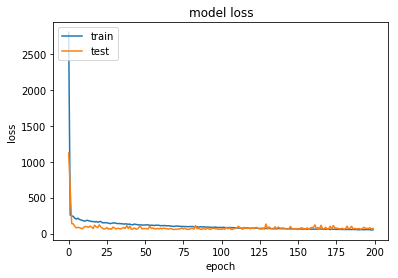

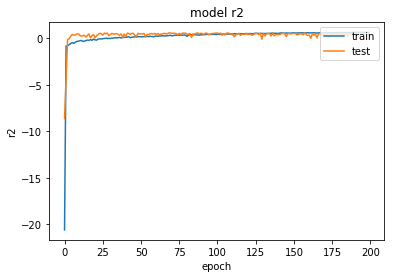

In [33]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r2')
plt.ylabel('r2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Observations:
1. We can easily see that model is predicting the Target variable brillianlty.
2. The Loss & R2 metric graphs converge after few epochs.
3. **No Overfitting.**

In [34]:
Dtest = pd.read_csv('test.csv')
# predict results
res = estimator.predict(test).ravel()
print(res)

# create df and convert it to csv
output = pd.DataFrame({'id': Dtest["ID"], 'y': res})
output.to_csv('Keras_final.csv', index=False)

4209/4209 [==============================] - 0s 84us/step
[ 76.85151   92.717636  74.61126  ...  93.58735  108.86175   92.010956]


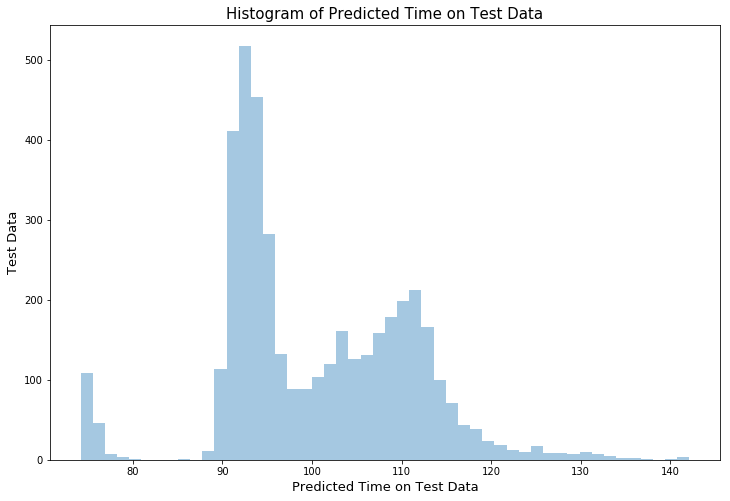

In [35]:
plt.figure(figsize=(12,8))
sns.distplot(output.y.values, bins=50, kde=False)
plt.xlabel('Predicted Time on Test Data', fontsize=13)
plt.ylabel('Test Data', fontsize=13)
plt.title('Histogram of Predicted Time on Test Data', fontsize=15)
plt.show()

### Observations:

1. The distribution of the Predicted Time (y) on Test Data is shifted left compared to the input data distribution.

# Models Performance Table 

## ![title](merc-benz.jpg) 

# Conclusion:
1. **We have taken the Mercedes-Benz Greener Manufacturing data.**
2. **We have trained ML & DL models on the data.** 
3. **Stacking model gives best performence.** 